In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [2]:
df=pd.read_csv(r"D:\pandas\IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
df.shape

(50000, 2)

In [5]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [6]:
df["sentiment"].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [7]:
df["review"]

0        One of the other reviewers has mentioned that ...
1        A wonderful little production. <br /><br />The...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a Catholic taught in parochial elementary...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 50000, dtype: object

In [8]:
df.duplicated().sum()

np.int64(418)

In [9]:
df["review_length"]=df["review"].apply(lambda x: len(x.split()))
df

,review,sentiment,review_length
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230
...,...,...,...
49995,I thought this movie did a down right good job...,positive,194
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,112
49997,I am a Catholic taught in parochial elementary...,negative,230
49998,I'm going to have to disagree with the previou...,negative,212


In [10]:
df.describe()

,review_length
count,50000.000000
mean,231.156940
std,171.343997
min,4.000000
25%,126.000000
50%,173.000000
75%,280.000000
max,2470.000000


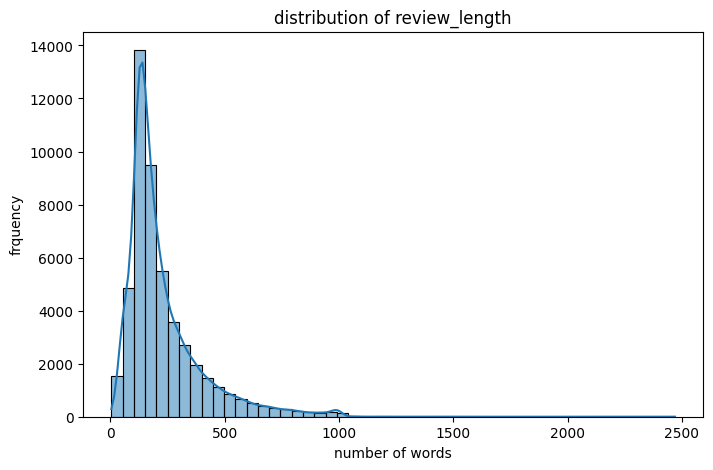

In [11]:
plt.figure(figsize=(8,5))
sns.histplot(df["review_length"],bins=50,kde=True)
plt.title("distribution of review_length")
plt.ylabel("frquency")
plt.xlabel("number of words")
plt.show()

In [12]:
df.review.iloc[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [13]:
def has_html(text):
    return bool(re.search(r"<.*?>",text))
print("number of reviews containing html tags",df["review"].apply(has_html).sum())

number of reviews containing html tags 29202


In [14]:
df=df.drop_duplicates().reset_index(drop=True)
print("length of dataset",len(df))

length of dataset 49582


In [15]:
def remove_html(text):
    return re.sub(r"<.*?>"," " ,text)

df["review"]=df["review"].apply(remove_html)

In [16]:
df["review"].apply(has_html).sum()

np.int64(0)

In [17]:
df.review.iloc[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.  The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.  It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.  I would say the main appeal of the show is due to the fact that it goes where other sh

In [18]:
def clean_special_char(text):
    text=re.sub(r"[^a-zA-Z\s]"," ",text)
    text=re.sub(r"\s+"," ",text)
    return text.strip()
df["review"]=df["review"].apply(clean_special_char)

In [19]:
df["review"]=df["review"].str.lower()

In [20]:
df.head()

,review,sentiment,review_length
0,one of the other reviewers has mentioned that ...,positive,307
1,a wonderful little production the filming tech...,positive,162
2,i thought this was a wonderful way to spend ti...,positive,166
3,basically there s a family where a little boy ...,negative,138
4,petter mattei s love in the time of money is a...,positive,230


In [21]:
tokenizer=Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df["review"])

sequences=tokenizer.texts_to_sequences(df["review"])

x=pad_sequences(sequences,maxlen=400, padding="post", truncating="post")

y=df["sentiment"].map({"positive":1,"negative":0}).values

In [22]:
x_train,x_test,y_train,y_test=train_test_split(df["review"],y,test_size=0.2,random_state=42)

In [23]:
vectorizer=TfidfVectorizer(max_features=20000,ngram_range=(1,2))
x_train_vectorizer=vectorizer.fit_transform(x_train)
x_test_vectorizer=vectorizer.transform(x_test)


In [24]:
clf=LogisticRegression(max_iter=200)
clf.fit(x_train_vectorizer,y_train)

LogisticRegression(max_iter=200)

In [25]:
y_pred=clf.predict(x_test_vectorizer)

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      4939
           1       0.89      0.92      0.91      4978

    accuracy                           0.90      9917
   macro avg       0.90      0.90      0.90      9917
weighted avg       0.90      0.90      0.90      9917

